<a href="https://colab.research.google.com/github/CFA-Institute-RPC/Synthetic-Data-For-Finance/blob/main/LLM/04-Qwen3_sentiment_analysis_with_synthetic_and_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Qwen3-0.6B with real + synthetic data

In this notebook we train the Qwen3-0.6B model on a combination of real and synthetic data to see if we can get an improvement in performance on the validation set. In this notebook, we'll randomly take 200 synthetic data samples and add them to our training data, to form an augmented dataset we'll use for fine-tuning.

**Note: This notebook requires usage of Google Colab's free T4 GPU in order to reproducibly run.**

# Installation

In [1]:
!pip install --no-deps bitsandbytes==0.45.5 accelerate==1.6.0 xformers==0.0.29.post3 peft==0.15.2 trl==0.15.2 triton==3.2.0 cut_cross_entropy==25.1.1 transformers==4.52.2
!pip install --no-deps git+https://github.com/jtaitRAS/unsloth-zoo.git@t4mixed  # Custom branch of unsloth-zoo allowing for T4 GPU compatibility
!pip install sentencepiece==0.2.0 protobuf<4.0.0 datasets==2.21.0 huggingface_hub==0.31.4 hf_transfer==0.1.9 tyro
!pip install --no-deps unsloth==2025.5.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
  Attempting uninstall: peft
    Found existing installation: peft 0.16.0
    Uninstalling peft-0.16.0:
      Successfully uninstalled peft-0.16.0
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.8.1
    Uninstalling accelerate-1.

# Import libraries

In [2]:
import torch
major_version, minor_version = torch.cuda.get_device_capability() # Outputs GPU compute capability version (major) and indicator (minor)
print(f"Major: {major_version}, Minor: {minor_version}")
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import random
from tqdm import tqdm # Add progress bar to for loops
from unsloth import FastLanguageModel
from unsloth import tokenizer_utils
from transformers import AutoTokenizer, Qwen3ForSequenceClassification
import torch.nn.functional as F


Major: 7, Minor: 5
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# In order to speed up fine-tuning, we trim the size of the classification head to contain only the number tokens (1, 2 etc) which reduces memory usage.
# The function below doesn't work if we alter the classification head of the model in this way - so we overwrite this function to not do anything
def do_nothing(*args, **kwargs):
  pass

tokenizer_utils.fix_untrained_tokens = do_nothing

# Load the model and tokenizer

In [4]:
# Load model
model_name = "unsloth/Qwen3-0.6B-Base";load_in_4bit = False # load_in_4bit controls whether to use 4-bit quantization for model weights to speed up training

# Number of sentiment classes
NUM_CLASSES = 3

# Defines the max no. of tokens in an input sentence. Unsloth uses RoPE scaling internally which means it doesn't matter if the LLM sees an input that is longer than this, so any number is fine. We stick with the default 2048.
max_seq_length = 2048

dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

# Load LLM and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

# Optimizing model fine-tuning

In [5]:
# Trim the classification head so the model can only output numbers 0-NUM_classes (0 is kept to make everything simpler)
number_token_ids = []

# Find and store the tokenizer-encoded representations of each label class (0,1,2,3) (we don't use 0 as a class label but we keep it for simplicity)
for i in range(0, NUM_CLASSES+1):
  number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
  # Keep only the number tokens from lm_head

# Keep only the weights corresponding to prediction of our class labels - we will train these weights during the fine-tuning process.
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids,:])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print('The old size of the classification head was:', old_shape)
print('The new size of the classification head is:', par.shape)

#Modify the shape of the classification head to par
model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # Used later to convert the tokenizer-encoded class labels to the new classification head


The old size of the classification head was: torch.Size([151936, 1024])
The new size of the classification head is: torch.Size([4, 1024])


In [6]:
from peft import LoftQConfig

# Set up QLoRA for model
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # rank of the low-rank matrices (A and B) used to approximate  weight updates during fine-tuning
    target_modules = [
        'lm_head',
        'q_proj', 'k_proj','v_proj','o_proj',
        'gate_proj', 'up_proj', 'down_proj'], # Specify the layers that you want to fine-tune
    lora_alpha = 16, # Represents a constant, each AB matrix is scaled by (lora_alpha / r). This is another hyperparameter to be optimized, but is conventionally set to r such that the matrix is scaled by 1.
    lora_dropout = 0, # Can change to any value from 0-1 but 0 is optimized - represents how many of the trained matrices to drop-out
    bias='none', # Whether to include bias terms to train - 'none' is optimized
    use_gradient_checkpointing = 'unsloth',
    random_state=42, # Set for reproducibility in re-initializing the values in the low-rank matrices
    use_rslora = True,

)
# Count number of trainable parameters
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.5.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
Trainable parameters: 10096640


# Loading the data
We now load the training data and the synthetic data, and extract a random 200 synthetic samples which we will add to the training dataset to increase the number of training samples from 822 to 1022.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('drive/MyDrive/data/train.csv')
train = train[['sentence','label']]

# Load the synthetic dataset
file_url ='https://github.com/CFA-Institute-RPC/Synthetic-Data-For-Finance/blob/857b145432b049c3a48c0a333bad7917d3e912f5/LLM/data/gpt_synthetic_data.csv?raw=true'
synthetic_data = pd.read_csv(file_url,index_col=0)

# Uncomment this if you want to run the notebook with your own synthetic data
#synthetic_data = pd.read_csv('drive/MyDrive/data/gpt_synthetic_data.csv',index_col=0)

# take a random subsample of 200 synthetic examples
synthetic_data_subsample = synthetic_data.sample(n=200,random_state=42) # Random state = 42 ensures the same 200 samples are sampled each time. Changing this number will alter the extracted samples, leading to different augmented datasets and different model performances


Mounted at /content/drive


In [8]:
# Format the data
augmented_data = pd.concat([train,synthetic_data_subsample])

# Save data
#augmented_data.to_csv('drive/MyDrive/data/augmented_data.csv',index=False)
# Create prompt for the Qwen3 model
prompt = """Here is a sentence related to a company:
{}

Classify the sentiment into one of the following:
class 1: Negative
class 2: Neutral
class 3: Positive

SOLUTION
The correct answer is: class {}"""


# This function takes a dataset as input, and for each row in the dataset, formats it into an LLM prompt such that the first {} is filled with the sentence and the second {} is the label.
def formatting_prompts_func(dataset_):
  sentences = []
  for i in range(len(dataset_['sentence'])):
    sentence_ = dataset_['sentence'].iloc[i]
    label_ = dataset_['label'].iloc[i]

    sentence = prompt.format(sentence_, label_)

    sentences.append(sentence)
  return sentences

# Apply formatting_prompts_func to the sentence row in the training dataset
augmented_data['sentence'] = formatting_prompts_func(augmented_data)

In [9]:
import datasets
augmented_dataset = datasets.Dataset.from_pandas(augmented_data, preserve_index=False)

In [10]:
from transformers import DataCollatorForLanguageModeling
from typing import List, Dict, Union, Any

class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
  def __init__(
      self,
      *args,
      mlm: bool = False, # Disable masked language modeling (mlm)
      ignore_index: int = -100, # Used to specify label indices to be ignored using the calculation of cross-entropy loss (e.g if we don't care about class label 0, we set ignore_index=0)
      **kwargs,
  ):

    super().__init__(*args, mlm=mlm, **kwargs) # Call the parent class (DataCollatorForLanguageModeling  and set mlm=False)
    self.ignore_index = ignore_index # Set the ignore_index value in the parent class

  def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
    batch = super().torch_call(examples) # Define the batch of training examples

    for i in range(len(examples)):
      # For each batch of examples, get the labels we're interested in predicting, get the pytorch tensor using .nonzero(), get the last row using [-1]
      last_token_idx = (batch['labels'][i] != self.ignore_index).nonzero()[-1].item()
      # Set all labels to ignore_index except for the last token
      batch['labels'][i, :last_token_idx] = self.ignore_index

      # If the last token in the sentence is 0,1,2, or 3, this was processed with the old tokenizer as number_token_ids[1], number_token_ids[2] etc.
      # However, these indexes don't exist in the new classification head, so we map the indexes to the new lm_head index instead
      batch['labels'][i, last_token_idx] = reverse_map[ batch['labels'][i, last_token_idx].item() ]

    return batch

  # Instantiate an instance of the custom collator which maps the old tokenizer to the new tokenizer
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

# Training the model

In [11]:
from trl import SFTTrainer
from transformers import TrainingArguments
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = augmented_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1, # Number of workers used to tokenize the data
    packing = False, # Whether to group shorter sentences together into a larger sentence - we set to False as we have group_by_length = True
    args = TrainingArguments( # Define training arguments
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        #logging_step = 1,
        optim = 'adamw_8bit',
        weight_decay = 0.01,
        lr_scheduler_type = 'cosine',
        seed = 42,
        output_dir = 'outputs',
        num_train_epochs = 3, # 3 is the default, more epochs can improve performance.
        report_to = 'none',
        group_by_length = True
    ),
    data_collator = collator,
    dataset_text_field='sentence'
)

Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1022 [00:00<?, ? examples/s]

In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,022 | Num Epochs = 3 | Total steps = 96
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss


In [13]:
FastLanguageModel.for_inference(model) # Speeds up inference
print()

In [14]:
# Save optimized weights and biases of current trimmed language model head
trimmed_lm_head = model.lm_head.weight.data.clone() # Clone the weights
trimmed_lm_head_bias = model.lm_head.bias.data.clone()if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device) # Save biases if present, otherwise, save biases as 0

# Re-construct the old language model head with the old shape
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size,hidden_dim),0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device) # Create torch tensor of 0 weights with shape [old_size, hidden_dim]
new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

# Fill in the trained weights and biases for the allowed tokens representing the classification labels (number_token_ids)
for new_idx, orig_token_id in enumerate(number_token_ids):
  new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
  new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

# Update the model's language model head weights and biases
with torch.no_grad():
  new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
  new_lm_head_module.weight.data.copy_(new_lm_head)
  new_lm_head_module.bias.data.copy_(new_lm_head_bias)
  model.lm_head.modules_to_save['default'] = new_lm_head_module


# Inference Time!

In [15]:
# Load validation data and view first few rows
val = pd.read_csv('drive/MyDrive/data/val.csv')
val = val[['sentence','label']]
val.head()

,sentence,label
0,S&P downgrades Barclays and RBS on government ...,1
1,Irish housebuilder Cairn Homes plans London li...,3
2,Arm slammed by handset sales outlook,1
3,CompaniesLSE adds ex-SEC head Schapiro to board,3
4,Sales boost for new Morrisons chief David Pott...,1


In [16]:
# Prepare inference prompt
# Create prompt for the model
prompt = """Here is a sentence related to a company:
{}

Classify the sentiment into one of the following:
class 1: Negative
class 2: Neutral
class 3: Positive

SOLUTION
The correct answer is: class {}"""

inference_prompt_template = prompt.split('class {}')[0] + 'class ' # Splits the prompt where

# Sort validation data by length for efficient batch processing
val['token_length'] = val['sentence'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_sorted = val.sort_values(by='token_length').reset_index(drop=True)

batch_size = 16 # Define batch_size
device = model.device
correct = 0 # Start counter of correct classifications

from sklearn.metrics import f1_score, classification_report

y_pred = []
y_true = []
with torch.inference_mode():
  for i in tqdm(range(0, len(val_sorted), batch_size), desc='Evaluating'):
    batch = val_sorted.iloc[i:i+batch_size] # Get the current batch
    prompts = [inference_prompt_template.format(text) for text in batch['sentence']] # Format each sentence into inference prompt template
    inputs = tokenizer(prompts, return_tensors ='pt', padding=True, truncation=True, max_length=max_seq_length).to(device) # Tokenize the input prompts
    logits = model(**inputs).logits # Get the logits (output from the model from last hidden layer)
    last_idxs = inputs.attention_mask.sum(1) -1 # attention_mask is a binary tensor containing the positions of tokens in each prompt that don't need to be attended to, e.g padding tokens used to standardize the prompt length, a value of 1 in the tensor is used to represent attended tokens. Here, we get the index of each attended token in each sentence in the attention_mask tensor and extract the index of the last attended token
    last_logits = logits[torch.arange(len(batch)), last_idxs, :] # Get the logits of the final token for each
    probs_all = F.softmax(last_logits, dim=-1) # Apply softmax function to final logits to convert logits into probabilities
    probs = probs_all[:, number_token_ids] # Only keep probabilities for the number tokens
    preds = torch.argmax(probs, dim=-1).cpu().numpy() # Predictions - shape is [1 1 2 3 1 2 3 ... ]

    y_pred.extend(preds.tolist()) # Append predicted labels to list
    y_true.extend(batch['label'].tolist()) # Append true labels to list

    true_labels = batch['label'].tolist() # Get true labels
    correct += sum([p == t for p, t in zip(preds, true_labels)])


overall_accuracy = 100 * correct / len(val_sorted)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation accuracy (Overall): {overall_accuracy:.2f}% ({correct}/{len(val_sorted)})")
print(f"\nValidation weighted F1-score: {f1_weighted:.4f}")


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


Validation accuracy (Overall): 84.62% (99/117)

Validation weighted F1-score: 0.8517


By augmenting our training data with 200 synthetic examples produced by ChatGPT - we see that the weighted F1-score on the validation set has increased from 75.21% to 85.17%.

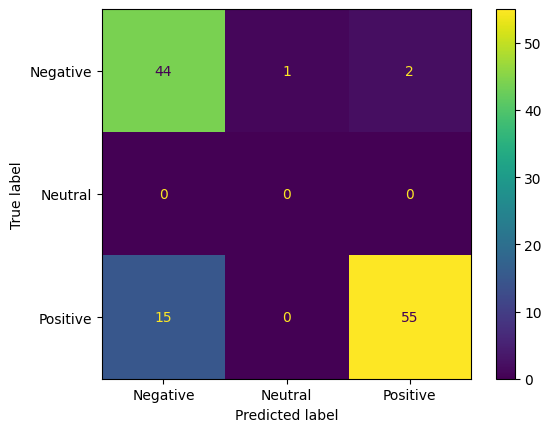

In [17]:
# Confusion matrix
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=['Negative','Neutral','Positive'])
disp.plot()
plt.savefig('drive/MyDrive/results/model_2_results.svg')
plt.show()

We see the model has gotten slightly better at correctly classifying the positive (label = 3) class. Can we improve the model even more by using more synthetic data - or will we experience a drop-off in performance? In the next notebook, we'll do some testing to find out.